Dataset: Breast Cancer Wisconsin
Shape X: (569, 30) | Clases: [np.str_('malignant'), np.str_('benign')]
-----------------------------


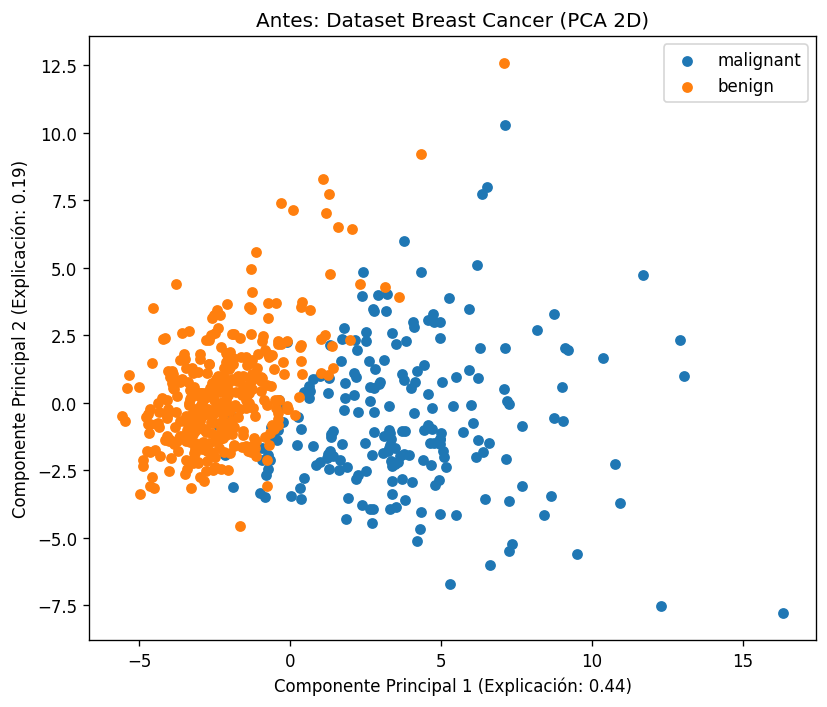


=== LinearSVC: Métricas (macro) ===
Accuracy:  0.9720
Precision: 0.9739
Recall:    0.9661
F1-score:  0.9698

=== LinearSVC: Reporte por clase ===
              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        53
      benign       0.97      0.99      0.98        90

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



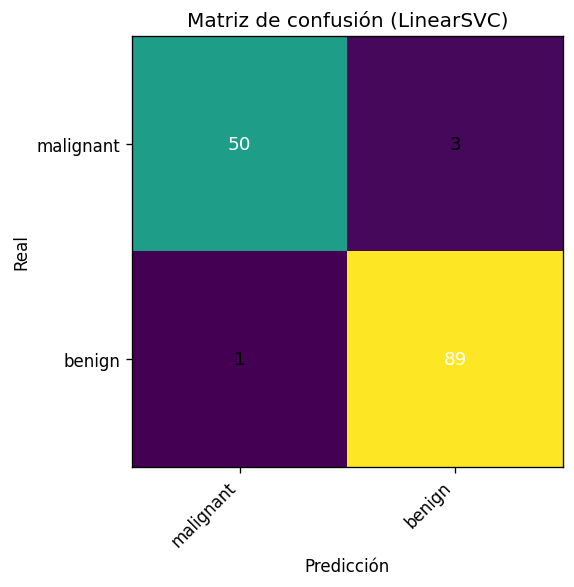

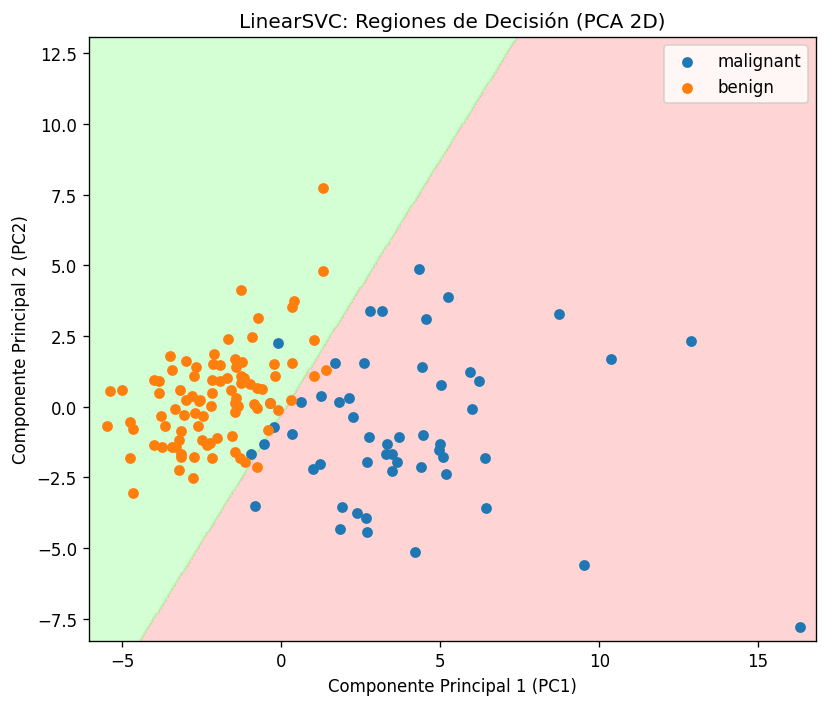

In [8]:
# ==========================================================
# === Breast Cancer + LinearSVC ===
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 

from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42

# -----------------------------
# 1) Cargar y Preparar Dataset
# -----------------------------
cancer = load_breast_cancer(as_frame=True)
X = cancer.data.copy()
y = cancer.target.copy()
target_names = cancer.target_names # ['malignant', 'benign']

print("Dataset: Breast Cancer Wisconsin")
print(f"Shape X: {X.shape} | Clases: {list(target_names)}")
print("-----------------------------")

# -----------------------------
# 1.A) Gráfica 'antes' (datos crudos, reducidos con PCA 2D)
# -----------------------------
# PCA se usa para visualizar las 30 características en 2D.
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled) # X_pca contiene [PC1, PC2] para TODO el dataset

plt.figure(figsize=(7, 6), dpi=120)
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                label=target_names[label], s=30)
plt.title("Antes: Dataset Breast Cancer (PCA 2D)")
plt.xlabel(f"Componente Principal 1 (Explicación: {pca.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"Componente Principal 2 (Explicación: {pca.explained_variance_ratio_[1]:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Split y Pipeline (Scaler -> LinearSVC) en datos originales
# -----------------------------
# Dividir el dataset original (30 características)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Definir el clasificador y el pipeline (El escalado es obligatorio para LinearSVC)
classifier = LinearSVC(random_state=RANDOM_STATE, dual='auto', max_iter=10000) 
pipe_lsvc = Pipeline([
    ("scaler", StandardScaler()),
    ("lsvc", classifier)
])
pipe_lsvc.fit(X_train, y_train)

# -----------------------------
# 2.A) Métricas
# -----------------------------
y_pred = pipe_lsvc.predict(X_test)

# Cálculo de las 4 métricas requeridas
acc = accuracy_score(y_test, y_pred)
# Usamos 'macro' para un promedio simple de las métricas por clase
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== LinearSVC: Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== LinearSVC: Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 2.B) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.viridis) 
plt.title("Matriz de confusión (LinearSVC)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
# Añadir los conteos a la matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11, 
                 color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Gráfica de Regiones de Decisión (Usando PCA 2D)
# -----------------------------
# Dividir los datos REDUCIDOS POR PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Entrenar un nuevo clasificador solo con las 2 componentes principales (PC1 y PC2)
classifier_2d = LinearSVC(random_state=RANDOM_STATE, dual='auto', max_iter=10000)
#  X_pca ya viene de datos escalados
classifier_2d.fit(X_train_pca, y_train_pca) 

# Crear la Malla (meshgrid) para mapear las regiones de decisión
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = classifier_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Graficar
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA']) # Colores para el fondo de la clasificación
plt.figure(figsize=(7, 6), dpi=120)

# Contorno de regiones de decisión
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

# Puntos de datos de prueba con su clase REAL para distinguir datos
for label in np.unique(y_test_pca):
    mask = (y_test_pca == label)
    pts = X_test_pca[mask]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=30)

plt.title("LinearSVC: Regiones de Decisión (PCA 2D)")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.legend()
plt.tight_layout()
plt.show()

Dataset: Breast Cancer Wisconsin
Shape X: (569, 30) | Clases: [np.str_('malignant'), np.str_('benign')]
-----------------------------


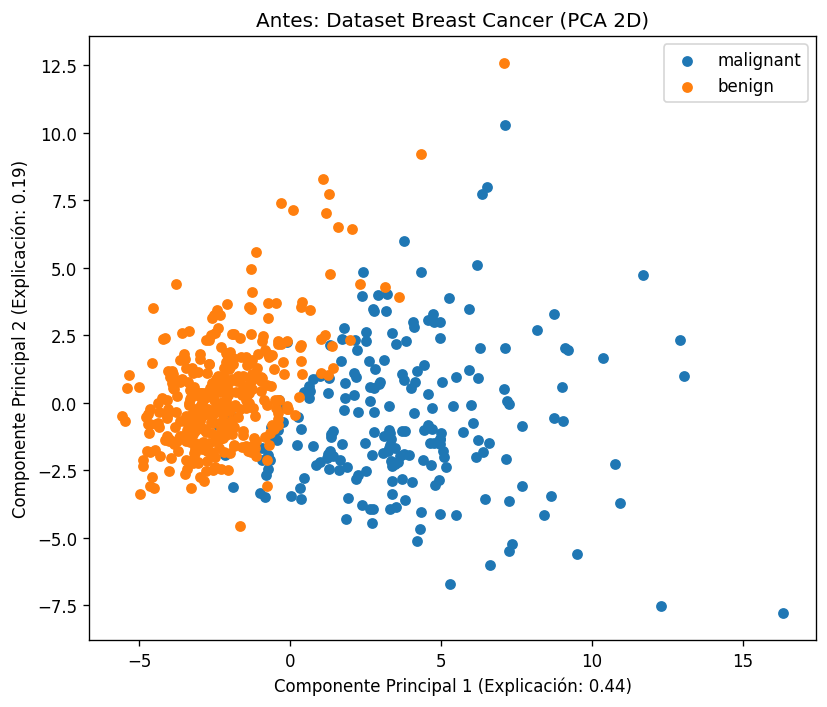


=== NuSVC: Métricas (macro) ===
Accuracy:  0.9301
Precision: 0.9371
Recall:    0.9134
F1-score:  0.9231

=== NuSVC: Reporte por clase ===
              precision    recall  f1-score   support

   malignant       0.96      0.85      0.90        53
      benign       0.92      0.98      0.95        90

    accuracy                           0.93       143
   macro avg       0.94      0.91      0.92       143
weighted avg       0.93      0.93      0.93       143



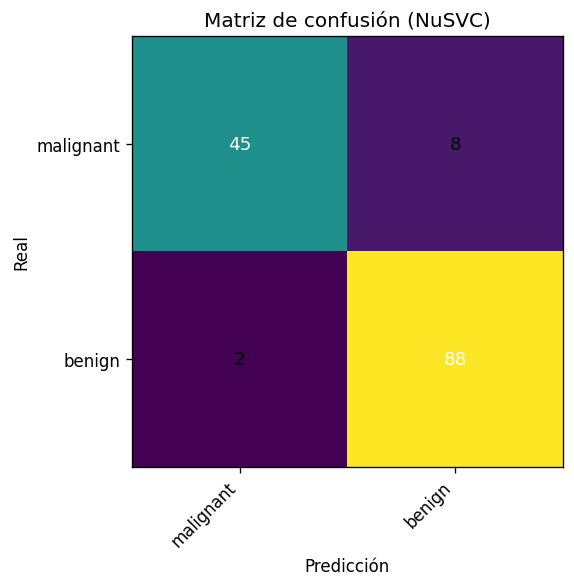

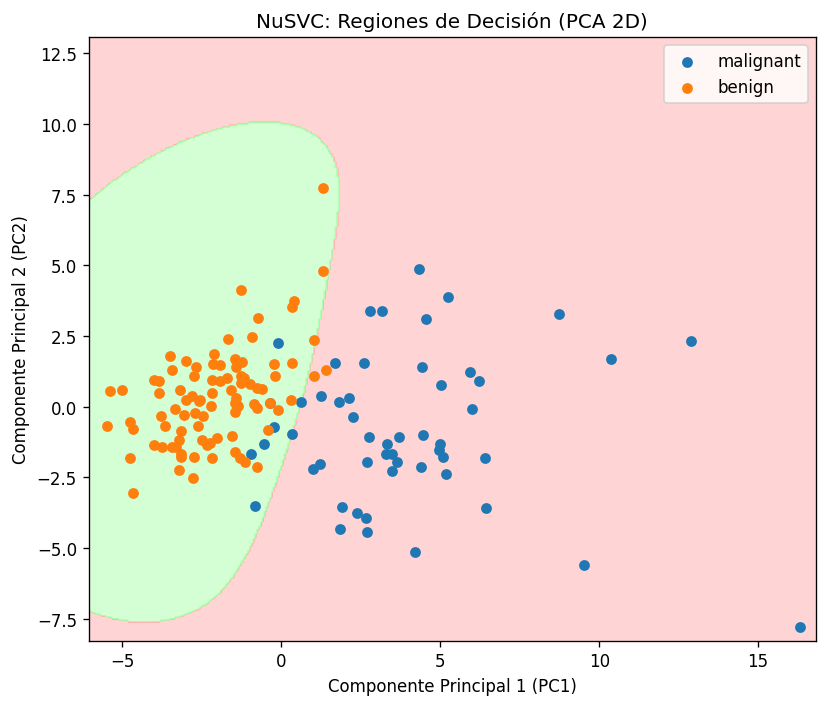

In [9]:
# ==========================================================
# === Breast Cancer + NuSVC  ===
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 

from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import NuSVC 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42

# -----------------------------
# 1) Cargar y Preparar Dataset
# -----------------------------
cancer = load_breast_cancer(as_frame=True)
X = cancer.data.copy()
y = cancer.target.copy()
target_names = cancer.target_names # ['malignant', 'benign']

print("Dataset: Breast Cancer Wisconsin")
print(f"Shape X: {X.shape} | Clases: {list(target_names)}")
print("-----------------------------")

# -----------------------------
# 1.A) Gráfica 'antes' (datos crudos, reducidos con PCA 2D)
# -----------------------------
# El escalado es crucial para PCA y SVC
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled) 

plt.figure(figsize=(7, 6), dpi=120)
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                label=target_names[label], s=30)
plt.title("Antes: Dataset Breast Cancer (PCA 2D)")
plt.xlabel(f"Componente Principal 1 (Explicación: {pca.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"Componente Principal 2 (Explicación: {pca.explained_variance_ratio_[1]:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Split y Entrenamiento con Pipeline (Scaler -> NuSVC) en datos originales
# -----------------------------
# Dividir el dataset original (30 características)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Definir el clasificador NuSVC
classifier = NuSVC(random_state=RANDOM_STATE, nu=0.5, probability=False) # nu=0.5 es el valor por defecto
pipe_nusvc = Pipeline([
    ("scaler", StandardScaler()),
    ("nusvc", classifier)
])
pipe_nusvc.fit(X_train, y_train)

# Predicción
y_pred = pipe_nusvc.predict(X_test)

# -----------------------------
# 2.A) Métricas
# -----------------------------
# Cálculo de las 4 métricas requeridas
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== NuSVC: Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== NuSVC: Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 2.B) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.viridis) 
plt.title("Matriz de confusión (NuSVC)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
# Añadir los conteos a la matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11, 
                 color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Gráfica de Regiones de Decisión (Usando PCA 2D)
# -----------------------------
# Dividir los datos REDUCIDOS POR PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Entrenar un nuevo clasificador NuSVC solo con las 2 componentes principales (PC1 y PC2)
classifier_2d = NuSVC(random_state=RANDOM_STATE, nu=0.5, probability=False)
classifier_2d.fit(X_train_pca, y_train_pca) 

# Crear la Malla (meshgrid) para mapear las regiones de decisión
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = classifier_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Graficar
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA']) # Colores para el fondo de la clasificación
plt.figure(figsize=(7, 6), dpi=120)

# Contorno de regiones de decisión
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

# Puntos de datos de prueba con su clase REAL para distinguir datos
for label in np.unique(y_test_pca):
    mask = (y_test_pca == label)
    pts = X_test_pca[mask]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=30)

plt.title("NuSVC: Regiones de Decisión (PCA 2D)")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.legend()
plt.tight_layout()
plt.show()

Dataset: Breast Cancer Wisconsin
Shape X: (569, 30) | Clases: [np.str_('malignant'), np.str_('benign')]
-----------------------------


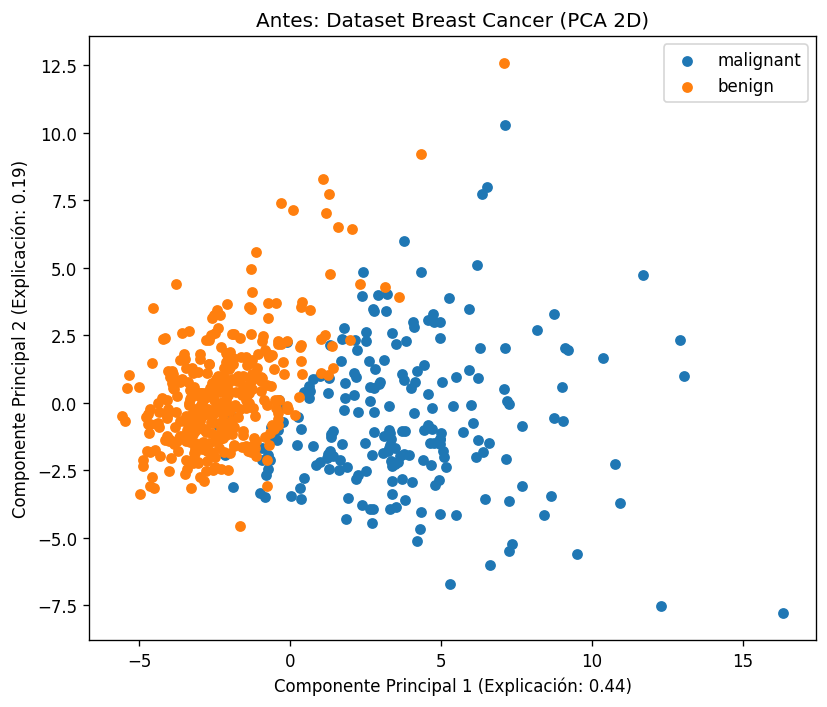


=== DecisionTreeClassifier: Métricas (macro) ===
Accuracy:  0.9371
Precision: 0.9312
Recall:    0.9345
F1-score:  0.9328

=== DecisionTreeClassifier: Reporte por clase ===
              precision    recall  f1-score   support

   malignant       0.91      0.92      0.92        53
      benign       0.96      0.94      0.95        90

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143



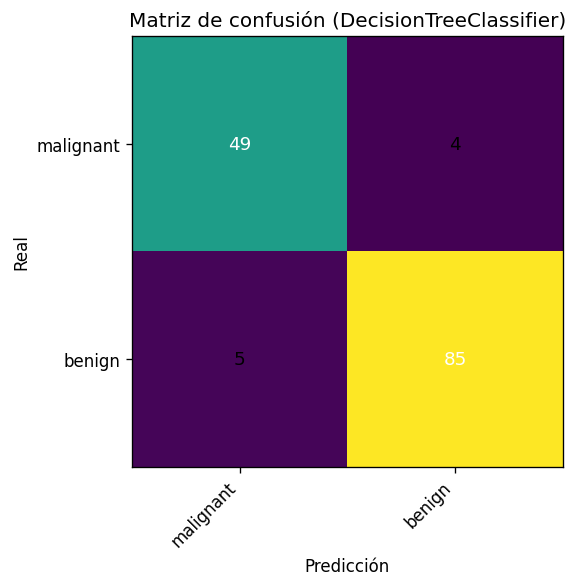

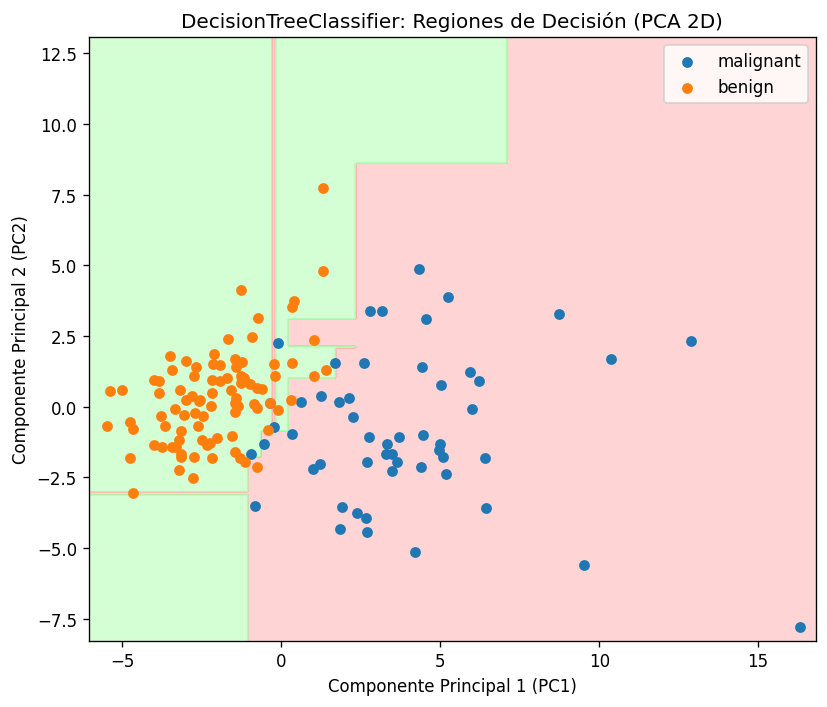

In [11]:
# ==========================================================
# === Breast Cancer + DecisionTreeClassifier  ===
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 

from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42

# -----------------------------
# 1) Cargar y Preparar Dataset
# -----------------------------
cancer = load_breast_cancer(as_frame=True)
X = cancer.data.copy()
y = cancer.target.copy()
target_names = cancer.target_names # ['malignant', 'benign']

print("Dataset: Breast Cancer Wisconsin")
print(f"Shape X: {X.shape} | Clases: {list(target_names)}")
print("-----------------------------")

# -----------------------------
# 1.A) Gráfica 'antes' (datos crudos, reducidos con PCA 2D)
# -----------------------------
# El escalado es crucial para PCA
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled) 

plt.figure(figsize=(7, 6), dpi=120)
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                label=target_names[label], s=30)
plt.title("Antes: Dataset Breast Cancer (PCA 2D)")
plt.xlabel(f"Componente Principal 1 (Explicación: {pca.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"Componente Principal 2 (Explicación: {pca.explained_variance_ratio_[1]:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Split y Entrenamiento con Pipeline (Scaler -> DecisionTreeClassifier)
# -----------------------------
# Dividir el dataset original (30 características)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Definir el clasificador DecisionTreeClassifier
# Añadimos un parámetro (max_depth) para evitar el sobreajuste
classifier = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5) 

# Nota: El scaler no es estrictamente necesario para el árbol, pero se mantiene 
# en el pipeline por si se quisiera comparar con otros modelos que lo requieren.
pipe_dtc = Pipeline([
    ("scaler", StandardScaler()),
    ("dtc", classifier)
])
pipe_dtc.fit(X_train, y_train)

# Predicción
y_pred = pipe_dtc.predict(X_test)

# -----------------------------
# 2.A) Métricas
# -----------------------------
# Cálculo de las 4 métricas requeridas
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== DecisionTreeClassifier: Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== DecisionTreeClassifier: Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 2.B) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.viridis) 
plt.title("Matriz de confusión (DecisionTreeClassifier)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
# Añadir los conteos a la matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11, 
                 color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Gráfica de Regiones de Decisión (Usando PCA 2D)
# -----------------------------
# Dividir los datos REDUCIDOS POR PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Entrenar un nuevo clasificador 2D (sin scaler, ya que X_pca está escalado)
classifier_2d = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5)
classifier_2d.fit(X_train_pca, y_train_pca) 

# Crear la Malla (meshgrid) para mapear las regiones de decisión
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = classifier_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Graficar
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA']) # Colores para el fondo de la clasificación
plt.figure(figsize=(7, 6), dpi=120)

# Contorno de regiones de decisión
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

# Puntos de datos de prueba con su clase REAL para distinguir datos
for label in np.unique(y_test_pca):
    mask = (y_test_pca == label)
    pts = X_test_pca[mask]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=30)

plt.title("DecisionTreeClassifier: Regiones de Decisión (PCA 2D)")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.legend()
plt.tight_layout()
plt.show()